In [101]:
# This script takes as inputs the log files of an alpha
# alpha swarm for varying number of agents N and
# produces a .csv output file

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv

from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm


%matplotlib inline

In [103]:
data_path = os.path.abspath('../alpha_alpha_swarm/data_N/')

In [104]:
file_paths = [os.path.join(data_path, f) for f in os.listdir(data_path)]

In [105]:
#file_path = file_paths[1]
file_path = '../alpha_alpha_swarm/data_N/N_200_T_1000.csv'

In [106]:
df = pd.read_csv(file_path)

In [107]:
num_agents = df.agent_id.max()

In [108]:
num_agents

200

In [109]:
num_ts = df.timestamp.max()

In [110]:
num_ts

10000

In [111]:
pos_cols = ['px', 'py', 'pz']
vel_cols = ['vx', 'vy', 'vz']
acc_cols = ['ax', 'ay', 'az']

In [112]:
pos = np.array([df[df.agent_id==i][pos_cols].as_matrix() for i in range(1, num_agents + 1)]).transpose(1, 0, 2)
vel = np.array([df[df.agent_id==i][vel_cols].as_matrix() for i in range(1, num_agents + 1)]).transpose(1, 0, 2)
acc = np.array([df[df.agent_id==i][acc_cols].as_matrix() for i in range(1, num_agents + 1)]).transpose(1, 0, 2)

In [113]:
a = np.arange(1, 10)

In [114]:
def plot_final_positions(pos):
    num_agents = pos.shape[1]
    ax = plt.subplot(111, projection='3d')
    for i in range(num_agents):
        ax.plot(pos[-2:-1:, i, 0], pos[-2:-1:, i, 1], pos[-2:-1:, i, 2], marker='o')
    plt.axis('equal')
    plt.show()

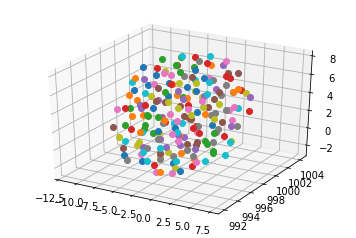

In [115]:
plot_final_positions(pos)

In [116]:
def plot_trajectory_tails(pos):
    num_agents = pos.shape[1]
    ax = plt.subplot(111, projection='3d')
    for i in range(num_agents):
        ax.plot(pos[-100:-1:, i, 0], pos[-100:-1:, i, 1], pos[-100:-1:, i, 2])
    plt.axis('equal')
    plt.show()

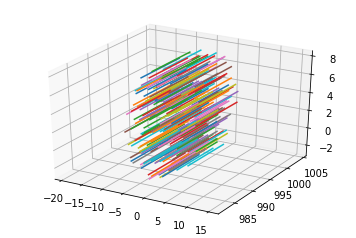

In [117]:
plot_trajectory_tails(pos)

In [118]:
def compute_distance_matrix(pos):
    _ , num_agents, _ = pos.shape
    distances = np.zeros((num_agents, num_agents))
    for i in range(num_agents):
        for j in range(num_agents):
            pi = pos[-10:-1:, i, :].mean(axis=0)
            pj = pos[-10:-1:, j, :].mean(axis=0)
            distances[i, j] = np.linalg.norm(pi - pj)
    return distances

def plot_distance_matrix(dm):
    num_agents = dm.shape[0]
    fig, ax = plt.subplots()
    ax.set_xticks(range(num_agents))
    ax.set_yticks(range(num_agents))
    ax.xaxis.tick_top()
    p = ax.imshow(dm, cmap='gray', interpolation='nearest')
    fig.colorbar(p)

In [119]:
distance_matrix = compute_distance_matrix(pos)

In [120]:
def compute_center(pos):
    num_agents, _ = pos.shape
    center = np.average(pos, axis=0)
    return center

def compute_dist_from_center(pos,center):
    dist = pos - center
    dist_norm = np.linalg.norm(dist, 2, axis=1);
    return dist_norm

In [121]:
center = compute_center(pos[-1,:,:])
dist_from_center = compute_dist_from_center(pos[-1,:,:],center)
print(center)

[ -2.22959742 998.0833       2.85228378]


In [125]:
def dist_center(dm, dist_from_center):
    num_agents = dm.shape[0]
    dm_sorted = dm
    dm_sorted.sort(axis=0)
    min_d = dm_sorted[1,:]
    coupled = np.vstack((np.arange(1, num_agents+1),dist_from_center,min_d)).T
    return coupled

In [126]:
coupled = dist_center(distance_matrix, dist_from_center)

No handles with labels found to put in legend.


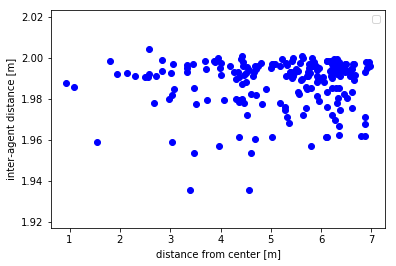

In [127]:
# Plot the inter-agent distance as a function of the distance from the center
x = coupled[:,1]
y = coupled[:,2]
plt.scatter(x, y, c='b')
plt.xlabel('distance from center [m]')
plt.ylabel('inter-agent distance [m]')
plt.legend()
plt.show()

In [128]:
def stats_on_distance(dm):
    num_agents = dm.shape[0]
    dm_sorted = dm
    dm_sorted.sort(axis=0)
    avg_min_d = dm_sorted[1,:].mean()
    std_min_d = dm_sorted[1,:].std()
    min_min_d = dm_sorted[1,:].min()
    min_min_d = dm_sorted[1,:].max()
    max_d = max(dm_sorted[num_agents-1,:])
    return avg_min_d, std_min_d, max_d

In [129]:
avg_min_d, std_min_d, min_min_d, max_min_d, max_d = stats_on_distance(distance_matrix)
print(avg_min_d, std_min_d, max_d)

ValueError: not enough values to unpack (expected 5, got 3)

In [65]:
def plot_acc_mag(acc):
    acc_mag = norm(acc, axis=2)
    plt.plot(acc_mag.max(axis=1))

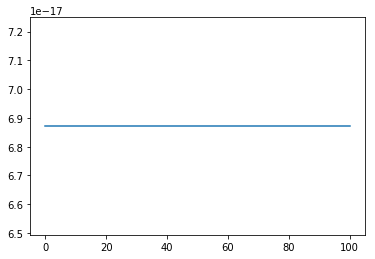

In [66]:
plot_acc_mag(acc)

In [68]:
# Example response generation routine

csv_file = open('distance_data_N.csv', 'w')
fieldnames = ['N', 'T', 'avg_min_d', 'std_min_d', 'min_min_d', 'max_min_d', 'max_d']
csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
csv_writer.writeheader()

for fp in file_paths:
    
    row = {}
    
    # Get factor values from file name
    _, file_name = os.path.split(fp)
    factor_list = file_name[:-4].split('_')
    
    for key, val in zip(factor_list[0::2], factor_list[1::2]):
        row[key] = val
    
    # Read raw data CSV file 
    df = pd.read_csv(fp)
    
    # Compute response 
    num_agents = df.agent_id.max()
    pos_cols = ['px', 'py', 'pz']
    acc_cols = ['ax', 'ay', 'az']
    pos = np.array([df[df.agent_id==i][pos_cols].as_matrix() for i in range(1, num_agents + 1)]).transpose(1, 0, 2)
    acc = np.array([df[df.agent_id==i][acc_cols].as_matrix() for i in range(1, num_agents + 1)]).transpose(1, 0, 2)
    distance_matrix = compute_distance_matrix(pos)
    avg_min_d, std_min_d, min_min_d, max_min_d, max_d = stats_on_distance(distance_matrix)
    
    # Write response row to CSV file
    row['avg_min_d'] = avg_min_d
    row['std_min_d'] = std_min_d
    row['min_min_d'] = min_min_d
    row['max_min_d'] = max_min_d
    row['max_d'] = max_d
    csv_writer.writerow(row)
    
csv_file.close()